In [25]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
plt.rcParams['figure.dpi'] = 90
plt.rcParams.update({'font.size': 12})

In [26]:
#define the shape of the environment (i.e., its states)
environment_rows = 10
environment_columns = 10
initial_node_energy = .7  # the initial energy of each node in the network
number_of_episodes = 1000
transmission_energy_cost = 0.007  # the amount of energy(mJ) consumed by a node to receive and forward a packet to 1 hop distance
active_mode_energy_cost = 0.0005  # the amount of energy(mj) cosumed by a node for being in active mode
sleep_mode_energy_cost = 0.00025  # the amount of energy(mj) cosumed by a node for being in sleep mode

#Create a 3D numpy array to hold the current Q-values for each state and action pair: Q(s, a) 
#The array contains 10 rows and 10 columns (to match the shape of the environment), as well as a third "action" dimension.
#The "action" dimension consists of 4 layers that will allow us to keep track of the Q-values for each possible action in
#each state (see next cell for a description of possible actions). 
#The value of each (state, action) pair is initialized to 0.
q_values1 = np.zeros((environment_rows, environment_columns, 4))
q_values2 = np.zeros((environment_rows, environment_columns, 4))
q_values3 = np.zeros((environment_rows, environment_columns, 4))
q_values4 = np.zeros((environment_rows, environment_columns, 4))

In [27]:
#define actions
#numeric action codes: 0 = up, 1 = right, 2 = down, 3 = left
actions = ['up', 'right', 'down', 'left']

In [28]:
#Define the environment and its functions
class WSN():
  def __init__(self, Q = None):
    self.Q = Q
  
  #define a function that simulate the function of SDN and control the behaviour of nodes
  def get_reward(self,row, column):
    #Create a 2D numpy array to hold the rewards for each state. 
    #The array contains 10 rows and 10 columns (to match the shape of the environment), and each value is initialized to -1.
    rewards = np.full((environment_rows, environment_columns), -1.)
    rewards[9, 9] = 1. #set the reward for the destination node (i.e., the goal) to 1

    #define malicious node(8 nodes) locations for rows 0 through 9
    malicious = {} #store locations in a dictionary
    malicious[1] = [5]
    malicious[2] = [1]
    malicious[3] = [2]
    malicious[4] = [3]
    malicious[5] = [4]
    malicious[6] = [5]
    malicious[7] = [8]
    malicious[8] = [3]

    # malicious[3] = [2]
    # malicious[4] = [3]
    # malicious[5] = [4]
    # malicious[6] = [5]
    # malicious[7] = [8]
    # malicious[8] = [3]

    # malicious[1] = [3,5]
    # malicious[2] = [1,6]
    # malicious[3] = [2,5]
    # malicious[4] = [3,6]
    # malicious[5] = [2]
    # malicious[6] = [5,7]
    # malicious[7] = [7,8]
    # malicious[8] = [1,3]

    #set the rewards for all maicious node
    for row_index in range(1, 9):
      for column_index in malicious[row_index]: 
        rewards[row_index, column_index] = -2.
    
    return rewards[row, column]
  
  #define a function that determines if the specified location is a terminal state(either a malicious node or the destination node)
  def is_terminal_state(self, current_row_index, current_column_index):
    #if the reward for this location is -1, then it is not a terminal state
    if self.get_reward(current_row_index, current_column_index) == -1.:
      return False
    else:
      return True

  #define a function that will choose a random, non-terminal starting location
  def get_starting_location(self):
    #get a random row and column index
    current_row_index = np.random.randint(environment_rows)
    current_column_index = np.random.randint(environment_columns)
    #continue choosing random row and column indexes until a non-terminal state is identified
    #(i.e., until the chosen state is a 'normal node').
    while self.is_terminal_state(current_row_index, current_column_index):
      current_row_index = np.random.randint(environment_rows)
      current_column_index = np.random.randint(environment_columns)
    return current_row_index, current_column_index

  #define an epsilon greedy algorithm that will choose which action to take next
  def get_next_action(self, current_row_index, current_column_index, epsilon):
    if np.random.random() > epsilon:
      return np.argmax(self.Q[current_row_index, current_column_index])
    else: #choose a random action
      return np.random.randint(4)
  
  #define a function that will get the next location based on the chosen action
  def get_next_location(self, current_row_index, current_column_index, action_index):
    new_row_index = current_row_index
    new_column_index = current_column_index
    if actions[action_index] == 'up' and current_row_index > 0:
      new_row_index -= 1
    elif actions[action_index] == 'right' and current_column_index < environment_columns - 1:
      new_column_index += 1
    elif actions[action_index] == 'down' and current_row_index < environment_rows - 1:
      new_row_index += 1
    elif actions[action_index] == 'left' and current_column_index > 0:
      new_column_index -= 1
    return new_row_index, new_column_index

In [29]:
"""
Algorithm based on work done by Bouzid et al. (2020). 

Bouzid, S. E., Serrestou, Y., Raoof, K., & Omri, M. N. (2020). Efficient routing protocol for wireless sensor network based on reinforcement learning. In 2020 5th International Conference on Advanced Technologies for Signal and Image Processing (ATSIP) (pp. 1-5). IEEE. 10.1109/ATSIP49331.2020.9231883

"""
def R2LTO(epsilone = 0, discount_factor = 0.2, learning_rate = 0.9):
    env = WSN(Q= q_values2)
    
    packet_delivery = []
    t_energy = []
    alive = []

    path_lenght = 0        
    nb_success = 0
    total_energy = 0 
    #hop = 0

    initial_energy = np.full((environment_rows, environment_columns), initial_node_energy)

    #run through 1000 training episodes
    for episode in range(number_of_episodes):
        #get the starting location for this episode
      row_index, column_index = env.get_starting_location()
  
      #initialize the consumed energy to zero for the curretn episode
      energy = 0
      path_lenght = 0
      alive_node = environment_rows * environment_columns

      #continue taking actions (i.e., moving) until we reach a terminal state
      #(i.e., until we reach the item packaging area or crash into an item storage location)
      while not env.is_terminal_state(row_index, column_index):
          #choose which action to take (i.e., where to move next)
          action_index = env.get_next_action(row_index, column_index, epsilone)

          #perform the chosen action, and transition to the next state (i.e., move to the next location)
          old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
          row_index, column_index = env.get_next_location(row_index, column_index, action_index)
    
          #calculate the reward for moving to the new state
          reward = env.get_reward(row_index, column_index)
          hop = 18-row_index-column_index
          R = initial_energy[row_index, column_index]/(hop+1)

    
          old_q_value = q_values2[old_row_index, old_column_index, action_index]
          temporal_difference = R + (discount_factor * np.max(q_values2[row_index, column_index])) - old_q_value

          #update the Q-value for the previous state and action pair
          new_q_value = old_q_value + (learning_rate * temporal_difference)
          q_values2[old_row_index, old_column_index, action_index] = new_q_value


          initial_energy -= active_mode_energy_cost
          initial_energy[old_row_index, old_column_index] -= transmission_energy_cost

          if initial_energy[row_index, column_index] <= 0:
              alive_node -= 1

          # If we have a reward, it means that our outcome is a success
          if reward == 1:
              nb_success += 1
          
          # add one step to path lenght
          path_lenght += 1
      
      alive.append(alive_node)
      packet_delivery.append(nb_success/(episode+1))
      
      energy = path_lenght*transmission_energy_cost + 100*path_lenght*active_mode_energy_cost
      total_energy += energy
      t_energy.append(total_energy)

    energy_efficiency = nb_success / total_energy
    print('Training complete!')
    print('number of packet delivered:', nb_success)
    print("delivery rate: ", nb_success / episode)
    print("Energy : ", total_energy)
    print("Energy efficiency: ", nb_success / total_energy)

    return(packet_delivery, t_energy, alive, energy_efficiency)

In [30]:
def RLBR(epsilone = 0, discount_factor = 0.2, learning_rate = 0.9):
    
    env = WSN(Q= q_values3)    
    
    packet_delivery = []        
    t_energy = []
    alive = []

    path_lenght = 0        
    nb_success = 0
    total_energy = 0 
    #hop = 0

    initial_energy = np.full((environment_rows, environment_columns), initial_node_energy)
    
    #run through 1000 training episodes
    for episode in range(number_of_episodes):
      #get the starting location for this episode
      row_index, column_index = env.get_starting_location()
  
      #initialize the consumed energy to zero for the current episode
      energy = 0
      path_lenght = 0
      alive_node = environment_rows * environment_columns

      #continue taking actions (i.e., moving) until we reach a terminal state
      #(i.e., until we reach the item packaging area or crash into an item storage location)
      while not env.is_terminal_state(row_index, column_index):
          #choose which action to take (i.e., where to move next)
          action_index = env.get_next_action(row_index, column_index, epsilone)

          #perform the chosen action, and transition to the next state (i.e., move to the next location)
          old_row_index, old_column_index = row_index, column_index #store the old row and column indexes
          row_index, column_index = env.get_next_location(row_index, column_index, action_index)
    
          #calculate the reward for moving to the new state
          hop = 18-row_index-column_index
          reward = env.get_reward(row_index, column_index)
          R = initial_energy[row_index, column_index]/(9 ** 2 *(hop+1))

    
          old_q_value = q_values3[old_row_index, old_column_index, action_index]
          temporal_difference = R + (discount_factor * np.max(q_values3[row_index, column_index])) - old_q_value

          #update the Q-value for the previous state and action pair
          new_q_value = old_q_value + (learning_rate * temporal_difference)
          q_values3[old_row_index, old_column_index, action_index] = new_q_value

          initial_energy -= active_mode_energy_cost
          initial_energy[old_row_index, old_column_index] -= transmission_energy_cost

          if initial_energy[row_index, column_index] <= 0:
              alive_node -= 1

          if reward == 1:
              nb_success += 1

          # add one step to path lenght
          path_lenght += 1

      alive.append(alive_node)
      packet_delivery.append(nb_success/(episode+1))
      energy = path_lenght*transmission_energy_cost + 100*path_lenght*active_mode_energy_cost
      total_energy += energy
      t_energy.append(total_energy)

    energy_efficiency = nb_success / total_energy
    print('Training complete!')
    print('number of packet delivered:', nb_success)
    print("delivery rate: ", nb_success / episode)
    print("Energy : ", total_energy)
    print("Energy efficiency: ", energy_efficiency)

    return(packet_delivery, t_energy, alive, energy_efficiency)

In [31]:
# functions and parameters for RLBEEP algorithm
MND_lon, MND_lat = environment_rows, environment_columns
DFR_min = 5
DFR_max = 55
sleep_counter = np.zeros((environment_rows, environment_columns), dtype=int)
sleep_thresh = 5

def get_distance(row1, col1, row2, col2):
    return np.sqrt((row1 - row2) ** 2 + (col1 - col2) ** 2)

def get_normalized_distance(row1, col1, row2, col2):
    return get_distance(row1, col1, row2, col2) / max(MND_lon, MND_lat)

# get n
def get_n(row1, col1, row2, col2):
    normalized_distance = get_normalized_distance(row1, col1, row2, col2)
    return (normalized_distance * (DFR_max - DFR_min)) + DFR_min


# 
def restrict_data_transmission(prev_min, prev_max, sensor_data, threshold):
    curr_min = min(prev_min, sensor_data)
    curr_max = max(prev_max, sensor_data)
    send_permit = bool(abs(curr_max - sensor_data) > threshold or abs(sensor_data - curr_min) > threshold)
    return send_permit, curr_min, curr_max


#
def sleep_scheduling(row, col, send_permit, sleep_thresh, sleep_counter):
    if send_permit:
        sleep_counter[row, col] = 0
    else:
        sleep_counter[row, col] += 1

    if sleep_counter[row, col] > sleep_thresh:
        return 'sleep'
    else:
        return 'active'


def check_sleep_mode(row, col):
    if sleep_counter[row, col] > sleep_thresh:
        return 'sleep'
    else:
        return 'active'

In [32]:
# 
def RLBEEP(epsilone=0, discount_factor=0.2, learning_rate=0.9):
    env = WSN(Q=q_values4)

    packet_delivery = []
    t_energy = []
    alive = []
    lifetime = []
    total_network_lifetime = 0

    path_lenght = 0
    nb_success = 0
    total_energy = 0
    # hop = 0

    initial_energy = np.full((environment_rows, environment_columns), initial_node_energy)

    # run through 1000 training episodes
    for episode in range(number_of_episodes):
        # get the starting location for this episode
        row_index, column_index = env.get_starting_location()

        alive_node = environment_rows * environment_columns

        # initialize the consumed energy to zero for the curretn episode
        energy = 0
        path_lenght = 0

        prev_min = float('inf')
        prev_max = -float('inf')

        # continue taking actions (i.e., moving) until we reach a terminal state
        # (i.e., until we reach the item packaging area or crash into an item storage location)
        while not env.is_terminal_state(row_index, column_index):
            data_transmission_threshold = 3
            # mock temperature sensor data (random.randint(-10, 40))
            send_permit, prev_min, prev_max = restrict_data_transmission(prev_min, prev_max, random.randint(-10, 40),
                                                                         data_transmission_threshold)
            node_state = sleep_scheduling(row_index, column_index, send_permit, sleep_thresh=sleep_thresh,
                                          sleep_counter=sleep_counter)

            if node_state == 'active':
                # choose which action to take (i.e., where to move next)
                action_index = env.get_next_action(row_index, column_index, epsilone)

                # perform the chosen action, and transition to the next state (i.e., move to the next location)
                old_row_index, old_column_index = row_index, column_index  # store the old row and column indexes
                row_index, column_index = env.get_next_location(row_index, column_index, action_index)

                # calculate the reward for moving to the new state
                reward = env.get_reward(row_index, column_index)
                # calculate the remaining number of hops needed to reach the destination node
                hop = 18 - row_index - column_index
                # represents the energy reward for moving to the next state (location) in the reinforcement learning algorithm.
                d = get_distance(row_index, column_index, old_row_index, old_column_index)
                R = initial_energy[row_index, column_index] / ((hop + 1) * (9 ** get_n(row_index, column_index, old_row_index, old_column_index)))

                old_q_value = q_values4[old_row_index, old_column_index, action_index]
                temporal_difference = R + (discount_factor * np.max(q_values4[row_index, column_index])) - old_q_value

                # update the Q-value for the previous state and action pair
                new_q_value = old_q_value + (learning_rate * temporal_difference)
                q_values4[old_row_index, old_column_index, action_index] = new_q_value

                # update the energy level of all node (node consume energy if turn on active mode)

                initial_energy[old_row_index, old_column_index] -= transmission_energy_cost

                # add one step to path lenght
                path_lenght += 1
                # add one step to total network lifetime
                total_network_lifetime += 1

                # if the energy level of any node is zero or less, it means that the node is died
                for row in range(environment_rows):
                    for column in range(environment_columns):
                        if check_sleep_mode(row, column) == 'sleep':
                            initial_energy[row, column] -= sleep_mode_energy_cost
                        else:
                            initial_energy[row, column] -= active_mode_energy_cost 

                        if initial_energy[row, column] <= 0:
                            lifetime.append(total_network_lifetime)

                # If we have a reward, it means that our outcome is a success
                if reward == 1:
                    nb_success += 1

                if initial_energy[row_index, column_index] <= 0:
                    alive_node -= 1
                    
            else:
                alive_node -= 1

        alive.append(alive_node)
        packet_delivery.append(nb_success / (episode + 1))
        
        sleep_count_num = 0
        for row in range(environment_rows):
            for column in range(environment_columns):
                if check_sleep_mode(row, column) == 'sleep':
                    sleep_count_num += 1

        energy = path_lenght * transmission_energy_cost + (100 - sleep_count_num) * path_lenght * active_mode_energy_cost + sleep_count_num * sleep_mode_energy_cost

        total_energy += energy
        t_energy.append(total_energy)

    if len(lifetime) == 0:
        lifetime.append(1000)

    life = []
    for x in range(number_of_episodes):
        life.append(x)

    energy_efficiency = nb_success / total_energy
    print('RLBEEP Training complete!')
    print('number of packet delivered:', nb_success)
    print("delivery rate: ", nb_success / episode)
    print("Energy : ", total_energy)
    print("Energy efficiency: ",  energy_efficiency)

    return packet_delivery, t_energy, alive ,  energy_efficiency

In [33]:
delivery2 , energy2, alive_node2, energy_efficiency = R2LTO()

Training complete!
number of packet delivered: 8
delivery rate:  0.008008008008008008
Energy :  389.5949999999995
Energy efficiency:  0.020534144432038423


In [34]:
delivery3 , energy3, alive_node3, energy_efficiency = RLBR()

Training complete!
number of packet delivered: 9
delivery rate:  0.009009009009009009
Energy :  394.04099999999994
Energy efficiency:  0.022840262815290797


In [35]:
delivery4 , energy4, alive_node4, energy_efficiency = RLBEEP()

RLBEEP Training complete!
number of packet delivered: 9
delivery rate:  0.009009009009009009
Energy :  376.2569999999998
Energy efficiency:  0.02391982076080978


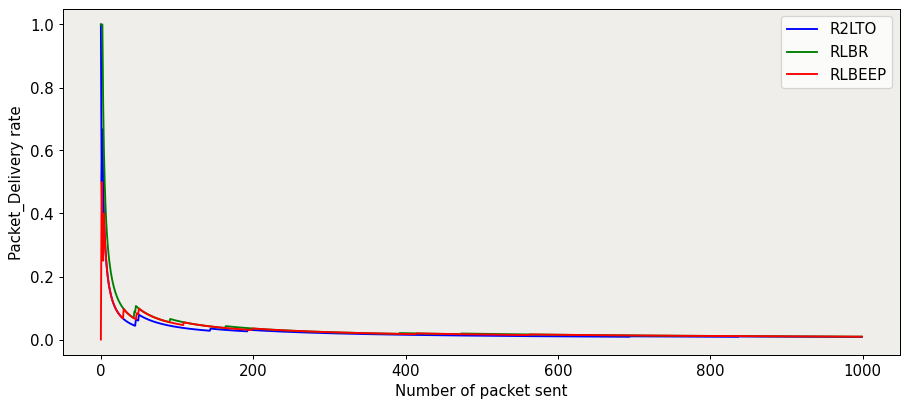

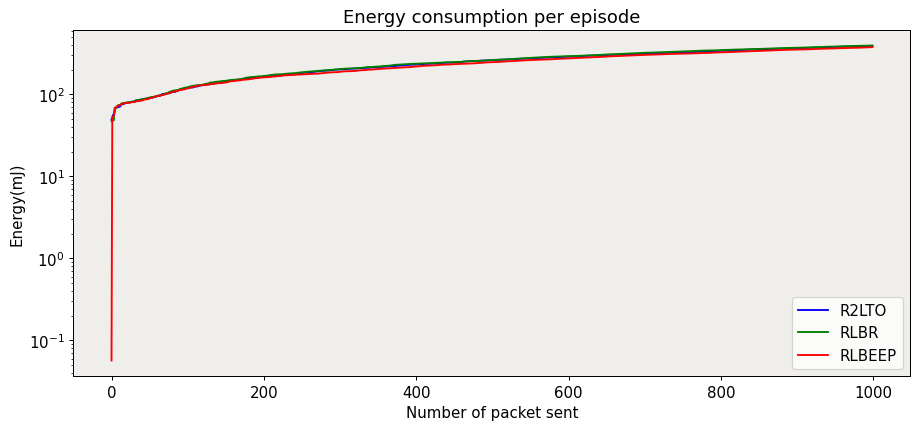

In [36]:
# Plot the result of two methods
x = range(len(delivery2))
plt.figure(figsize=(12, 5))
plt.plot(x, delivery2, color='b', label='R2LTO')
plt.plot(x, delivery3, color='g', label='RLBR')
plt.plot(x, delivery4, color='r', label='RLBEEP')
plt.xlabel("Number of packet sent")
plt.ylabel("Packet_Delivery rate")
ax = plt.gca()
ax.set_facecolor('#efeeea')
plt.legend()
plt.show()

x2 = range(len(energy2))
plt.figure(figsize=(12, 5))
plt.plot(x2, energy2, color='b', label='R2LTO')
plt.plot(x2, energy3, color='g', label='RLBR')
plt.plot(x2, energy4, color='r', label='RLBEEP')
plt.xlabel("Number of packet sent")
plt.ylabel("Energy(mJ)")
plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('#efeeea')
plt.legend()
plt.title("Energy consumption per episode")
plt.show()

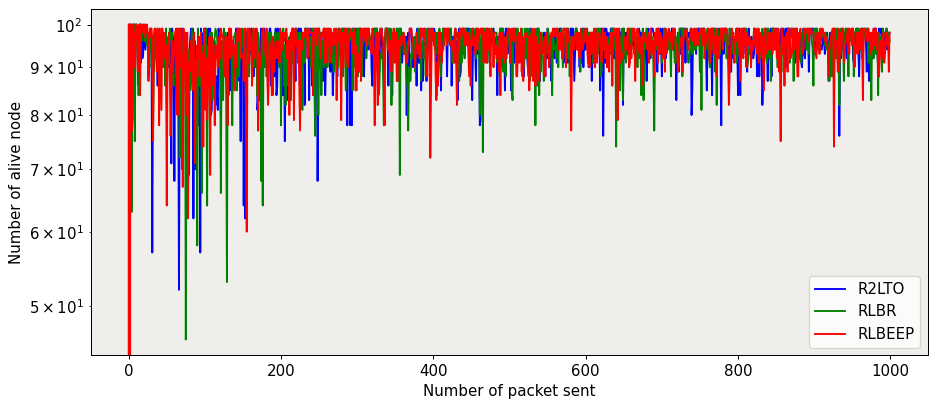

In [37]:
# Plot networks' lifetime

x = range(len(alive_node2))
plt.figure(figsize=(12, 5))
plt.plot(x, alive_node2, color='b', label='R2LTO')
plt.plot(x, alive_node3, color='g', label='RLBR')
plt.plot(x, alive_node4, color='r', label='RLBEEP')
plt.xlabel("Number of packet sent")
plt.ylabel("Number of alive node")
plt.yscale('log')
ax = plt.gca()
ax.set_facecolor('#efeeea')
plt.legend()
plt.show()

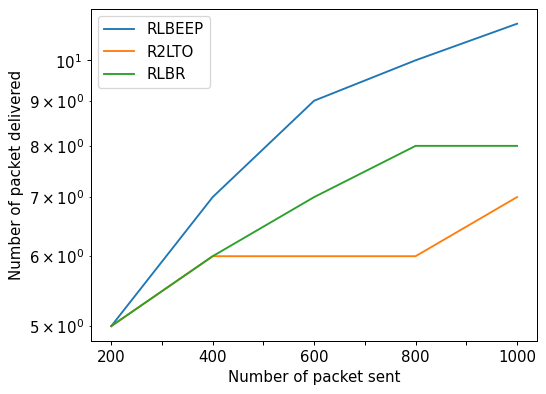

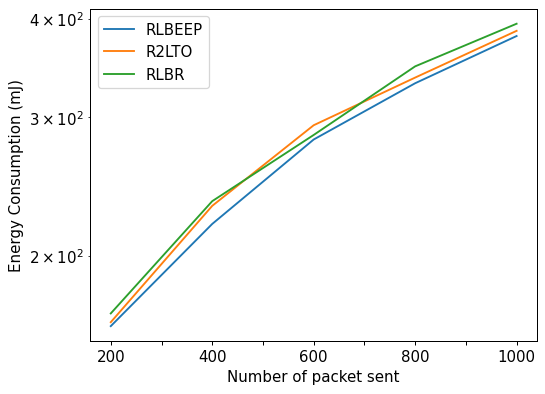

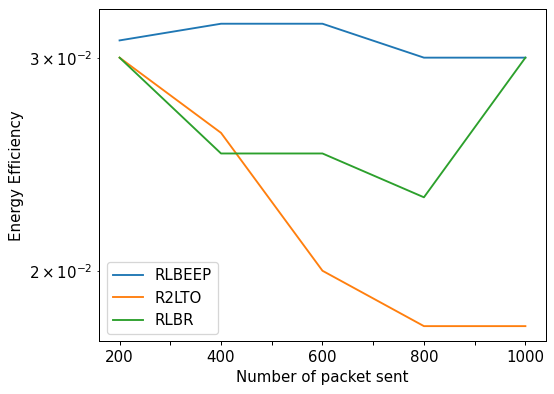

In [38]:
index_p = ['200','400','600','800','1000']

# revised code
packet_delivered ={ 'RLBEEP':[5, 7, 9, 10, 11], 'R2LTO':[5, 6, 6, 6, 7], 'RLBR':[5, 6, 7, 8, 8]}
energy_consumed = { 'RLBEEP':[163.02, 219.73, 281.18, 331.40, 380.42], 'R2LTO':[164.90, 231.65, 293.15, 336.93, 386.23], 'RLBR':[169.18, 234.84, 284.94, 348.16, 394.33]}
energy_efficiency = {'RLBEEP':[0.031, 0.032, 0.032, 0.030, 0.030], 'R2LTO':[0.030, 0.026, 0.020, 0.018, 0.018], 'RLBR':[0.030, 0.025, 0.025, 0.023, 0.030 ]}

# Number of packet delivered for different number of packet sent
vaiable_packet_p = pd.DataFrame({ 'RLBEEP':packet_delivered['RLBEEP'], 'R2LTO':packet_delivered['R2LTO'], 'RLBR':packet_delivered['RLBR']}, index = index_p)
# Energy consumed for different number of packet sent
vaiable_packet_e = pd.DataFrame({ 'RLBEEP':energy_consumed['RLBEEP'], 'R2LTO':energy_consumed['R2LTO'], 'RLBR':energy_consumed['RLBR']}, index = index_p)
#  Energy efficiency for different number of packet sent
vaiable_packet_ee = pd.DataFrame({ 'RLBEEP':energy_efficiency['RLBEEP'], 'R2LTO':energy_efficiency['R2LTO'], 'RLBR':energy_efficiency['RLBR']}, index = index_p)


# ax = vaiable_packet_p.plot.bar(rot=0)
# ax.set_xlabel("Number of packet sent")
# ax.set_ylabel("Number of packet delivered")
# ax.set_yscale('log')

ax_ = vaiable_packet_p.plot.line(rot=0)
ax_.set_xlabel("Number of packet sent")
ax_.set_ylabel("Number of packet delivered")
ax_.set_yscale('log')

# ax2 = vaiable_packet_e.plot.bar(rot=0)
# ax2.set_xlabel("Number of packet sent")
# ax2.set_ylabel("Energy Consumption (mJ)")
# ax2.set_yscale('log')

ax2 = vaiable_packet_e.plot.line(rot=0)
ax2.set_xlabel("Number of packet sent")
ax2.set_ylabel("Energy Consumption (mJ)")
ax2.set_yscale('log')

# ax3 = vaiable_packet_ee.plot.bar(rot=0)
# ax3.set_xlabel("Number of packet sent")
# ax3.set_ylabel("Energy Efficiency")
# ax3.set_yscale('log')

ax4 = vaiable_packet_ee.plot.line(rot=0)
ax4.set_xlabel("Number of packet sent")
ax4.set_ylabel("Energy Efficiency")
ax4.set_yscale('log')

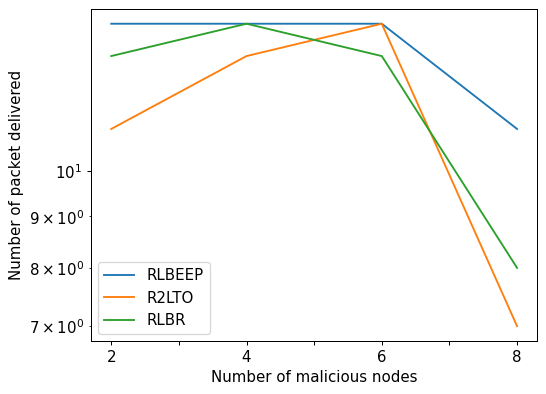

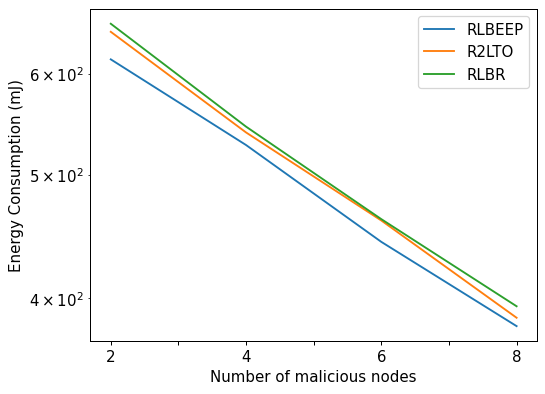

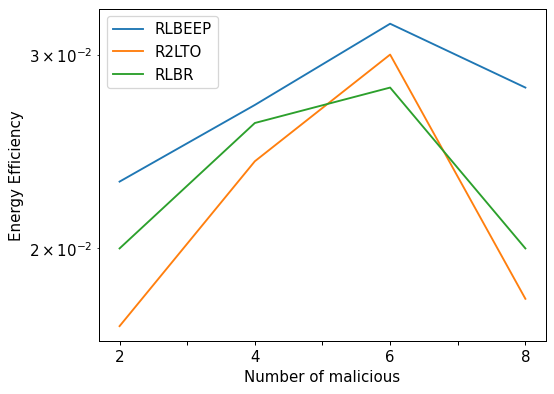

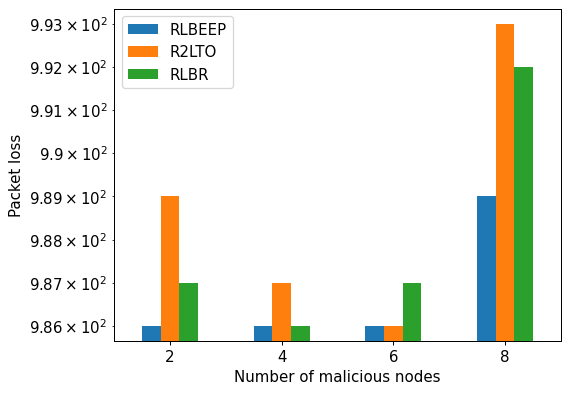

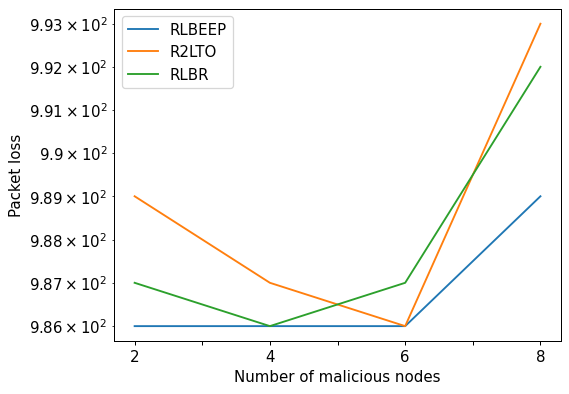

In [39]:
index_m = ['2', '4', '6', '8']

############# revised code
packet_delivered1 ={ 'RLBEEP':[14, 14, 14, 11], 'R2LTO':[11, 13, 14, 7], 'RLBR':[13, 14, 13, 8]}
energy_consumed1 = { 'RLBEEP':[616.17, 527.76, 443.00, 380.42], 'R2LTO':[647.63, 539.90, 460.45, 386.23], 'RLBR':[657.15, 545.60, 461.59, 394.33]}
energy_efficiency1 = {'RLBEEP':[0.023, 0.027, 0.032, 0.028], 'R2LTO':[0.017, 0.024, 0.030, 0.018], 'RLBR':[0.020, 0.026, 0.028, 0.020]}
packet_loss = {'RLBEEP':[10, 18, 26, 34], 'R2LTO':[941, 956, 919, 980], 'RLBR':[906, 919, 894, 983]}

# Number of packet delivered for different number of malicious nodes
vaiable_malicious_p = pd.DataFrame({'RLBEEP':packet_delivered1['RLBEEP'], 'R2LTO':packet_delivered1['R2LTO'], 'RLBR':packet_delivered1['RLBR']}, index = index_m)
#Average energy consumed for different number of malicious nodes
vaiable_malicious_e = pd.DataFrame({ 'RLBEEP':energy_consumed1['RLBEEP'], 'R2LTO':energy_consumed1['R2LTO'], 'RLBR':energy_consumed1['RLBR']}, index = index_m)
#  Energy efficiency for different number of malicious nodes
vaiable_malicious_ee = pd.DataFrame({ 'RLBEEP':energy_efficiency1['RLBEEP'], 'R2LTO': energy_efficiency1['R2LTO'], 'RLBR': energy_efficiency1['RLBR']}, index = index_m)
# Packet lost for different number of malicious nodes
vaiable_malicious_pl = pd.DataFrame({ 'RLBEEP':[986, 986, 986, 989], 'R2LTO':[989, 987, 986, 993], 'RLBR':[987, 986, 987, 992]}, index = index_m)

# axis = vaiable_malicious_p.plot.bar(rot=0)
# axis.set_xlabel("Number of malicious nodes")
# axis.set_ylabel("Number of packet delivered")
# axis.set_yscale('log')

axis_ = vaiable_malicious_p.plot.line(rot=0)
axis_.set_xlabel("Number of malicious nodes")
axis_.set_ylabel("Number of packet delivered")
axis_.set_yscale('log')

# axis2 = vaiable_malicious_e.plot.bar(rot=0)
# axis2.set_xlabel("Number of malicious nodes")
# axis2.set_ylabel("Energy Consumption (mJ)")
# axis2.set_yscale('log')

axis2_ = vaiable_malicious_e.plot.line(rot=0)
axis2_.set_xlabel("Number of malicious nodes")
axis2_.set_ylabel("Energy Consumption (mJ)")
axis2_.set_yscale('log')

# axis3 = vaiable_malicious_ee.plot.bar(rot=0)
# axis3.set_xlabel("Number of malicious nodes")
# axis3.set_ylabel("Energy Efficiency")
# axis3.set_yscale('log')

axis4 = vaiable_malicious_ee.plot.line(rot=0)
axis4.set_xlabel("Number of malicious")
axis4.set_ylabel("Energy Efficiency")
axis4.set_yscale('log')

axis5 = vaiable_malicious_pl.plot.bar(rot=0)
axis5.set_xlabel("Number of malicious nodes")
axis5.set_ylabel("Packet loss")
axis5.set_yscale('log')

axis5_ = vaiable_malicious_pl.plot.line(rot=0)
axis5_.set_xlabel("Number of malicious nodes")
axis5_.set_ylabel("Packet loss")
axis5_.set_yscale('log')